In [1]:
pip install opencv-python scikit-learn pandas tensorflow pillow matplotlib seaborn tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from keras.utils import normalize, to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import glob
import itertools

In [3]:
img_directory = 'dataset/'

# List image files
no_tumor_images = os.listdir(img_directory + 'Negative/')
yes_tumor_images = os.listdir(img_directory + 'Positive/')

In [4]:
dataset = []
label = []
new_size = (64, 64)

# Load and preprocess 'no tumor' images for non-CNN models
for image_name in no_tumor_images:
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(img_directory + 'Negative/' + image_name)
        if image is not None:
            image = Image.fromarray(image, 'RGB')
            image = image.resize(new_size)
            dataset.append(np.array(image).flatten())
            label.append(0)

# Load and preprocess 'yes tumor' images for non-CNN models
for image_name in yes_tumor_images:
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(img_directory + 'Positive/' + image_name)
        if image is not None:
            image = Image.fromarray(image, 'RGB')
            image = image.resize(new_size)
            dataset.append(np.array(image).flatten())
            label.append(1)
dataset = np.array(dataset)
label = np.array(label)


# Model Training

In [5]:
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

In [6]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [7]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train_scaled, y_train)
joblib.dump(knn_model, 'brain_tumor_knn_model.pkl')

['brain_tumor_knn_model.pkl']

In [8]:
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(x_train_scaled, y_train)
joblib.dump(dt_model, 'brain_tumor_dt_model.pkl')

['brain_tumor_dt_model.pkl']

In [9]:
x_train_cnn = normalize(x_train.reshape(-1, 64, 64, 3), axis=1)
x_test_cnn = normalize(x_test.reshape(-1, 64, 64, 3), axis=1)
y_train_cnn = to_categorical(y_train, num_classes=2)
y_test_cnn = to_categorical(y_test, num_classes=2)

In [10]:
basic_cnn_model = Sequential()
basic_cnn_model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Activation('relu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
basic_cnn_model.add(Dropout(0.25))

basic_cnn_model.add(Conv2D(64, (3, 3), kernel_initializer="he_uniform"))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Activation('relu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
basic_cnn_model.add(Dropout(0.25))

basic_cnn_model.add(Conv2D(128, (3, 3), kernel_initializer="he_uniform"))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Activation('relu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
basic_cnn_model.add(Dropout(0.25))

basic_cnn_model.add(Conv2D(256, (3, 3), kernel_initializer="he_uniform"))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Activation('relu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
basic_cnn_model.add(Dropout(0.25))

basic_cnn_model.add(Flatten())
basic_cnn_model.add(Dense(256))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Activation('relu'))
basic_cnn_model.add(Dropout(0.5))

basic_cnn_model.add(Dense(128))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Activation('relu'))
basic_cnn_model.add(Dropout(0.5))

basic_cnn_model.add(Dense(2))
basic_cnn_model.add(Activation('softmax'))

basic_cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history_cnn1 = basic_cnn_model.fit(x_train_cnn, y_train_cnn, batch_size=32, epochs=15, validation_data=(x_test_cnn, y_test_cnn), shuffle=True, callbacks=[early_stopping, reduce_lr])
basic_cnn_model.save('BrainTumor_Complex_CNN.h5')

C:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7000 - loss: 0.6423 - val_accuracy: 0.3966 - val_loss: 1.2494 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8984 - loss: 0.2845 - val_accuracy: 0.3966 - val_loss: 2.0086 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9278 - loss: 0.1866 - val_accuracy: 0.3966 - val_loss: 1.8062 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9276 - loss: 0.1752 - val_accuracy: 0.6120 - val_loss: 0.5762 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9451 - loss: 0.1486 - val_accuracy: 0.5218 - val_loss: 1.3034 - learning_rate: 0.0010
Epoch 6/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9544 - loss: 0.1160 - val_accuracy: 0.4146 - val_loss: 2.5518 - learning_rate: 0.0010
Epoch 7/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9621 - loss: 0

In [11]:
cnn_model = Sequential()

# First Convolutional Block
cnn_model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3), kernel_initializer="he_uniform"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Second Convolutional Block
cnn_model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer="he_uniform"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Third Convolutional Block
cnn_model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer="he_uniform"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Fourth Convolutional Block
cnn_model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer="he_uniform"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Fifth Convolutional Block
cnn_model.add(Conv2D(512, (3, 3), padding='same', kernel_initializer="he_uniform"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Sixth Convolutional Block
cnn_model.add(Conv2D(512, (3, 3), padding='same', kernel_initializer="he_uniform"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Flattening Layer
cnn_model.add(Flatten())

# Fully Connected Layers
cnn_model.add(Dense(256))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(128))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(2))
cnn_model.add(Activation('softmax'))

# Compile the Model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the Model
history_cnn2 = cnn_model.fit(x_train_cnn, y_train_cnn, batch_size=32, epochs=15, validation_data=(x_test_cnn, y_test_cnn), shuffle=True, callbacks=[early_stopping, reduce_lr])

# Save the Model
cnn_model.save('BrainTumor_24Layer_CNN.h5')


Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.6944 - loss: 0.7045 - val_accuracy: 0.8245 - val_loss: 0.5456 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.9007 - loss: 0.2652 - val_accuracy: 0.4288 - val_loss: 0.9092 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.9250 - loss: 0.1961 - val_accuracy: 0.4972 - val_loss: 0.6535 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.9409 - loss: 0.1678 - val_accuracy: 0.9412 - val_loss: 0.1834 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.9500 - loss: 0.1399 - val_accuracy: 0.7827 - val_loss: 0.4819 - learning_rate: 0.0010
Epoch 6/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.9508 - loss: 0.1481 - val_accuracy: 0.9203 - val_loss: 0.1767 - learning_rate: 0.0010
Epoch 7/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9599 

In [52]:
from keras.models import load_model
import pandas as pd
import io
import sys

# Function to parse model summary
def parse_model_summary(model):
    # Redirect stdout to capture the model summary
    buffer = io.StringIO()
    sys.stdout = buffer
    model.summary()
    sys.stdout = sys.__stdout__
    
    # Read the summary from the buffer
    summary_str = buffer.getvalue()
    summary_lines = summary_str.split('\n')
    
    # Process lines to extract layer information
    summary_list = []
    for line in summary_lines[1:-4]:  # Skip the first and last few lines
        parts = line.split()
        if len(parts) > 4:
            layer_name = parts[0]
            layer_type = parts[1]
            output_shape = parts[2]
            num_params = parts[4]
            summary_list.append([layer_name, layer_type, output_shape, num_params])
    
    # Convert the list to a DataFrame
    df = pd.DataFrame(summary_list, columns=['Layer Name', 'Layer Type', 'Output Shape', 'Param #'])
    
    return df

# Load the pre-trained model
model_path = 'BrainTumor_24Layer_CNN.h5'  # Replace with your model filename
model = load_model(model_path)

# Get and print the summary DataFrame
model_summary_df = parse_model_summary(model)
print(model_summary_df)

# Optionally, save the DataFrame to a CSV file
model_summary_df.to_csv('model_summary.csv', index=False)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,100,420 (15.64 MB)

 Trainable params: 4,096,642 (15.63 MB)

 Non-trainable params: 3,776 (14.75 KB)

 Optimizer params: 2 (12.00 B)

# Performance metrics


In [12]:
# Load models
knn_model = joblib.load('brain_tumor_knn_model.pkl')
dt_model = joblib.load('brain_tumor_dt_model.pkl')
basic_cnn_model = load_model('BrainTumor_Complex_CNN.h5')
cnn_model = load_model('BrainTumor_24Layer_CNN.h5')


In [13]:

# Evaluate KNN model
knn_y_pred = knn_model.predict(x_test_scaled)
knn_accuracy = accuracy_score(y_test, knn_y_pred)

# Evaluate Decision Tree model
dt_y_pred = dt_model.predict(x_test_scaled)
dt_accuracy = accuracy_score(y_test, dt_y_pred)

# Evaluate Basic CNN model
basic_cnn_y_pred_prob = basic_cnn_model.predict(x_test_cnn)
basic_cnn_y_pred = np.argmax(basic_cnn_y_pred_prob, axis=1)
basic_cnn_y_test = np.argmax(y_test_cnn, axis=1)
basic_cnn_accuracy = accuracy_score(basic_cnn_y_test, basic_cnn_y_pred)

# Evaluate Modified CNN model
cnn_y_pred_prob = cnn_model.predict(x_test_cnn)
cnn_y_pred = np.argmax(cnn_y_pred_prob, axis=1)
cnn_y_test = np.argmax(y_test_cnn, axis=1)
cnn_accuracy = accuracy_score(cnn_y_test, cnn_y_pred)

# Store the accuracies
accuracies = {
    'Decision Tree': dt_accuracy,
    'KNN': knn_accuracy,
    'Basic CNN': basic_cnn_accuracy,
    'Modified CNN': cnn_accuracy
}

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


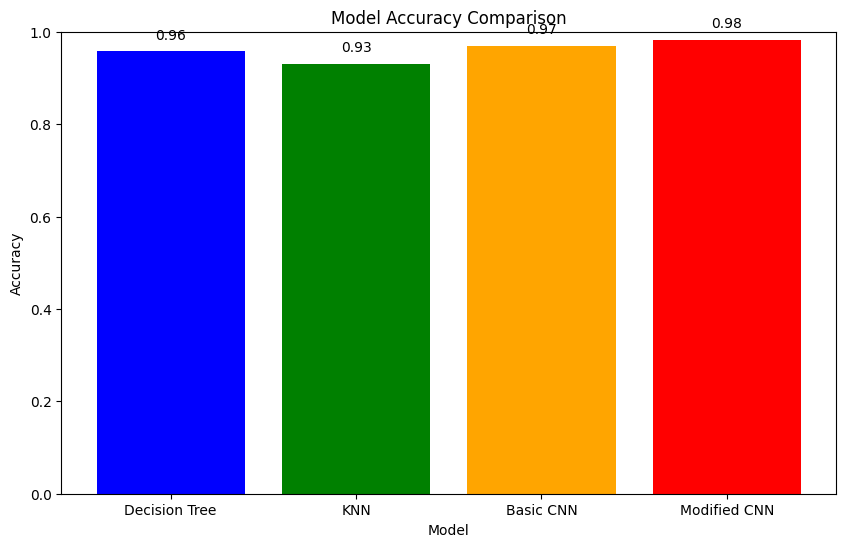

In [14]:
# Extract model names and accuracy values
model_names = list(accuracies.keys())
accuracy_values = list(accuracies.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1 for accuracy percentages

# Add accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.show()


In [15]:
def plot_comparison_training_history(histories, titles):
    plt.figure(figsize=(14, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    for history, title in zip(histories, titles):
        plt.plot(history.history['accuracy'], label=f'{title} - Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{title} - Validation Accuracy')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    for history, title in zip(histories, titles):
        plt.plot(history.history['loss'], label=f'{title} - Train Loss')
        plt.plot(history.history['val_loss'], label=f'{title} - Validation Loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


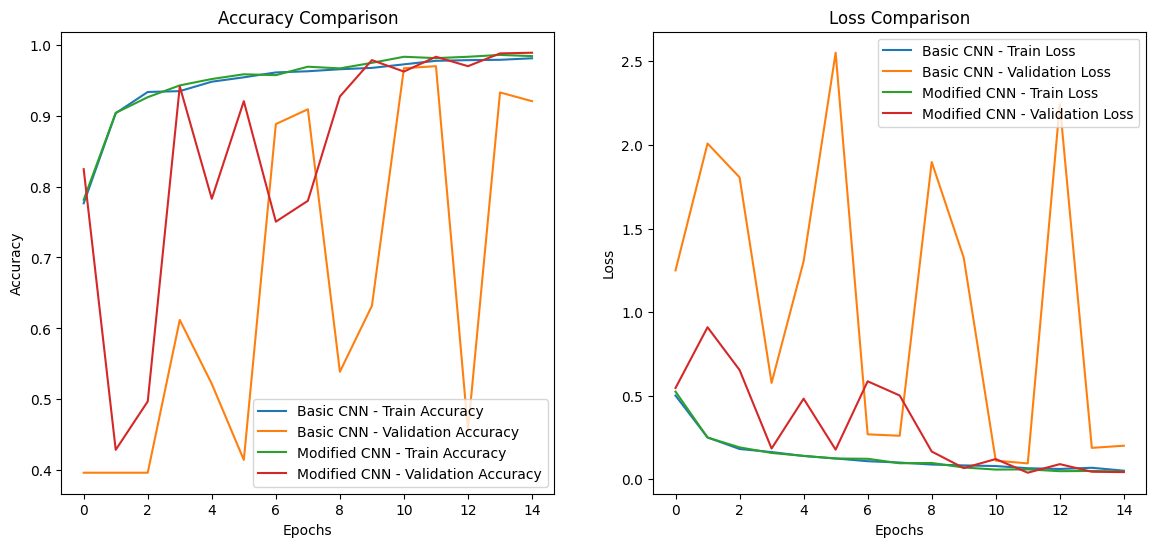

In [16]:
plot_comparison_training_history([history_cnn1, history_cnn2], ['Basic CNN', 'Modified CNN'])

In [17]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
def evaluate_non_cnn_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    y_proba = model.predict_proba(x_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    return accuracy, conf_matrix, class_report, y_proba

# CNN model evaluations
def evaluate_cnn_model(cnn_model, x_test, y_test):
    y_pred_prob = cnn_model.predict(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    return accuracy, conf_matrix, class_report

In [21]:
# Models to evaluate
models = {
    'Decision Tree': dt_model,
    'KNN': knn_model,
}

cnn_models = {
    'Basic CNN': basic_cnn_model,
    'Modified CNN': cnn_model
}

model_names = list(models.keys())
cnn_model_names = list(cnn_models.keys())


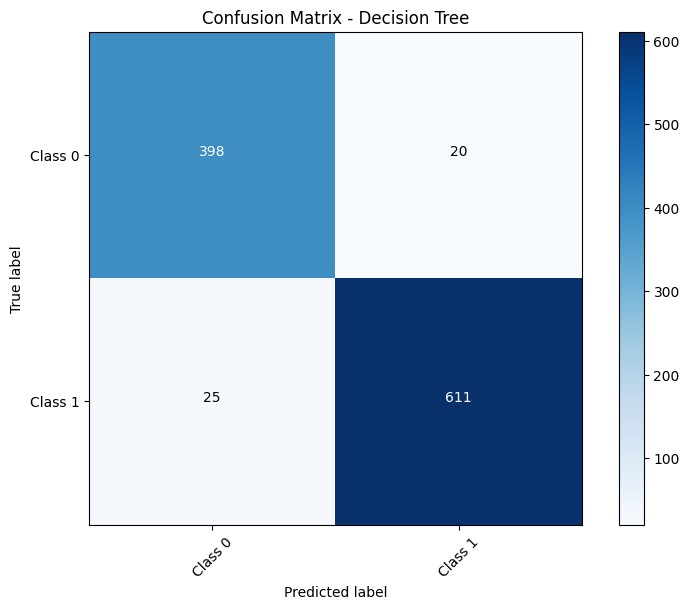

Decision Tree Metrics:
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       418
           1       0.97      0.96      0.96       636

    accuracy                           0.96      1054
   macro avg       0.95      0.96      0.96      1054
weighted avg       0.96      0.96      0.96      1054



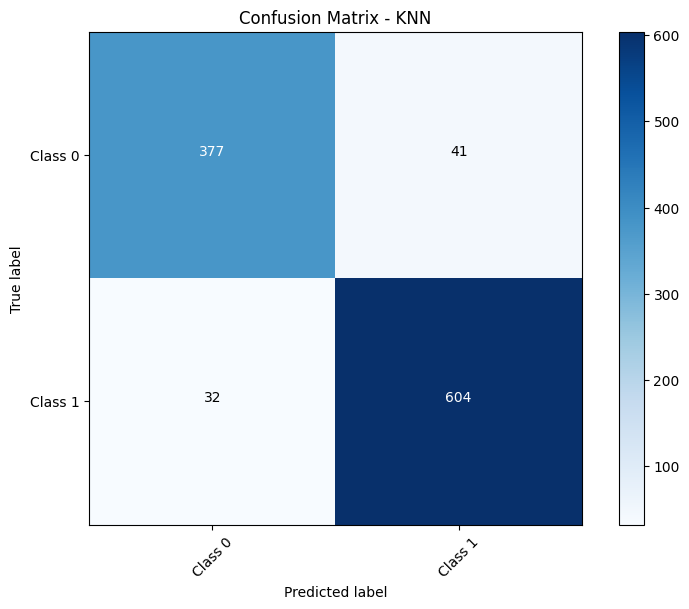

KNN Metrics:
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       418
           1       0.94      0.95      0.94       636

    accuracy                           0.93      1054
   macro avg       0.93      0.93      0.93      1054
weighted avg       0.93      0.93      0.93      1054

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


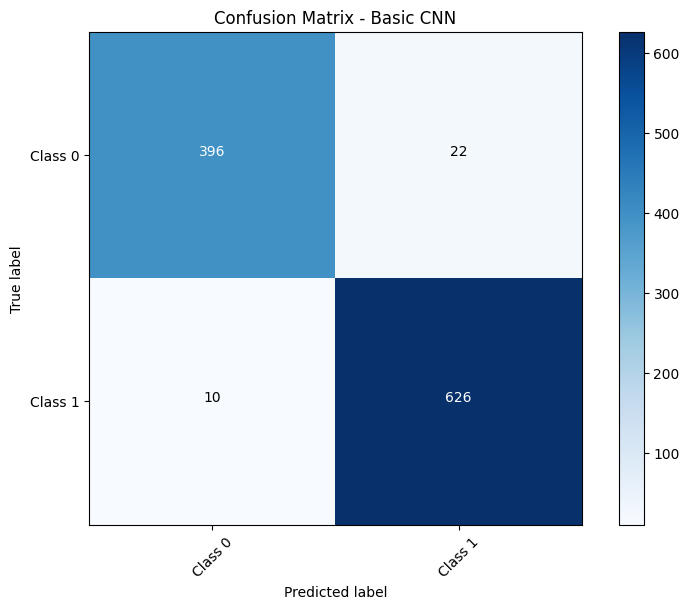

Basic CNN Metrics:
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       418
           1       0.97      0.98      0.98       636

    accuracy                           0.97      1054
   macro avg       0.97      0.97      0.97      1054
weighted avg       0.97      0.97      0.97      1054

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


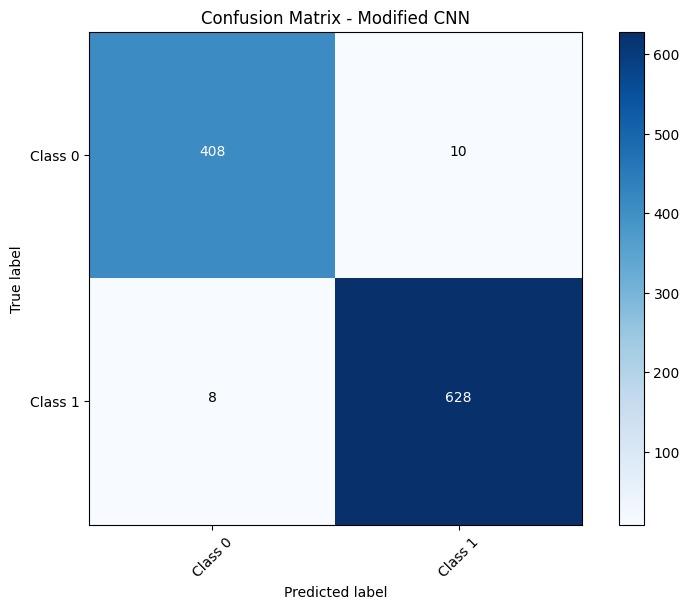

Modified CNN Metrics:
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       418
           1       0.98      0.99      0.99       636

    accuracy                           0.98      1054
   macro avg       0.98      0.98      0.98      1054
weighted avg       0.98      0.98      0.98      1054



In [41]:
for name, model in models.items():
    accuracy, conf_matrix, class_report, y_proba = evaluate_non_cnn_model(model, x_test_scaled, y_test)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(conf_matrix, classes=['Class 0', 'Class 1'], title=f'Confusion Matrix - {name}')
    plt.show()
    
    # Print metrics
    print(f"{name} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(class_report)

# Evaluate CNN models
for name, cnn_model in cnn_models.items():
    accuracy, conf_matrix, class_report = evaluate_cnn_model(cnn_model, x_test_cnn, y_test_cnn)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(conf_matrix, classes=['Class 0', 'Class 1'], title=f'Confusion Matrix - {name}')
    plt.show()
    
    # Print metrics
    print(f"{name} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(class_report)

In [27]:
knn_preds = knn_model.predict(x_test_scaled)
dt_preds = dt_model.predict(x_test_scaled)

In [28]:
basic_cnn_preds = basic_cnn_model.predict(x_test_cnn)
basic_cnn_preds = np.argmax(basic_cnn_preds, axis=1)
modified_cnn_preds = cnn_model.predict(x_test_cnn)
modified_cnn_preds = np.argmax(modified_cnn_preds, axis=1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


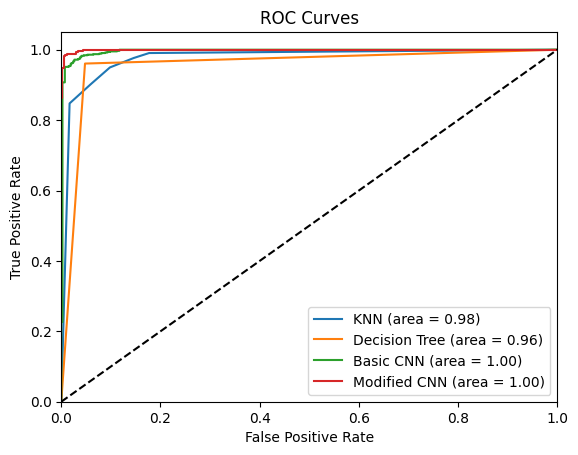

In [29]:
# ROC Curve for KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_model.predict_proba(x_test_scaled)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

# ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_model.predict_proba(x_test_scaled)[:, 1])
roc_auc_dt = auc(fpr_dt, tpr_dt)

# ROC Curve for Basic CNN
fpr_basic_cnn, tpr_basic_cnn, _ = roc_curve(np.argmax(y_test_cnn, axis=1), basic_cnn_model.predict(x_test_cnn)[:, 1])
roc_auc_basic_cnn = auc(fpr_basic_cnn, tpr_basic_cnn)

# ROC Curve for Modified CNN
fpr_modified_cnn, tpr_modified_cnn, _ = roc_curve(np.argmax(y_test_cnn, axis=1), cnn_model.predict(x_test_cnn)[:, 1])
roc_auc_modified_cnn = auc(fpr_modified_cnn, tpr_modified_cnn)

# Plot ROC Curves
plt.figure()
plt.plot(fpr_knn, tpr_knn, label=f'KNN (area = {roc_auc_knn:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (area = {roc_auc_dt:.2f})')
plt.plot(fpr_basic_cnn, tpr_basic_cnn, label=f'Basic CNN (area = {roc_auc_basic_cnn:.2f})')
plt.plot(fpr_modified_cnn, tpr_modified_cnn, label=f'Modified CNN (area = {roc_auc_modified_cnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Predictions 


In [30]:
pred_directory = 'pred'
new_size = (64, 64)

In [31]:
cnn_model = load_model('BrainTumor_24Layer_CNN.h5')

In [32]:
def preprocess_image(image_path, size):
    image = cv2.imread(image_path)
    if image is not None:
        image = Image.fromarray(image, 'RGB')
        image = image.resize(size)
        return np.array(image)
    return None

In [33]:
# List image files in the pred directory
pred_images = glob.glob(os.path.join(pred_directory, '*'))
pred_images_data = []
pred_images_names = []

In [34]:
for image_path in pred_images:
    image_name = os.path.basename(image_path)
    image_data = preprocess_image(image_path, new_size)
    if image_data is not None:
        pred_images_data.append(image_data)
        pred_images_names.append(image_name)

pred_images_data = np.array(pred_images_data)

In [35]:
pred_images_cnn = normalize(pred_images_data.astype('float32'), axis=1)

In [36]:
cnn_predictions_prob = cnn_model.predict(pred_images_cnn)
cnn_predictions = np.argmax(cnn_predictions_prob, axis=1)
cnn_predictions_conf = np.max(cnn_predictions_prob, axis=1) 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


In [37]:
def display_results(images, predictions, probabilities, names):
    num_images = 25
    max_images_per_row = 5  # Adjust this value as needed

    # Ensure the number of subplots does not exceed the maximum
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row
    
    plt.figure(figsize=(15, 3 * num_rows))
    
    for i in range(num_images):
        plt.subplot(num_rows, max_images_per_row, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Image: {names[i]}\nPred: {"Tumor" if predictions[i] == 1 else "No Tumor"}\nConf: {probabilities[i]:.2f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Modified CNN Model Predictions:


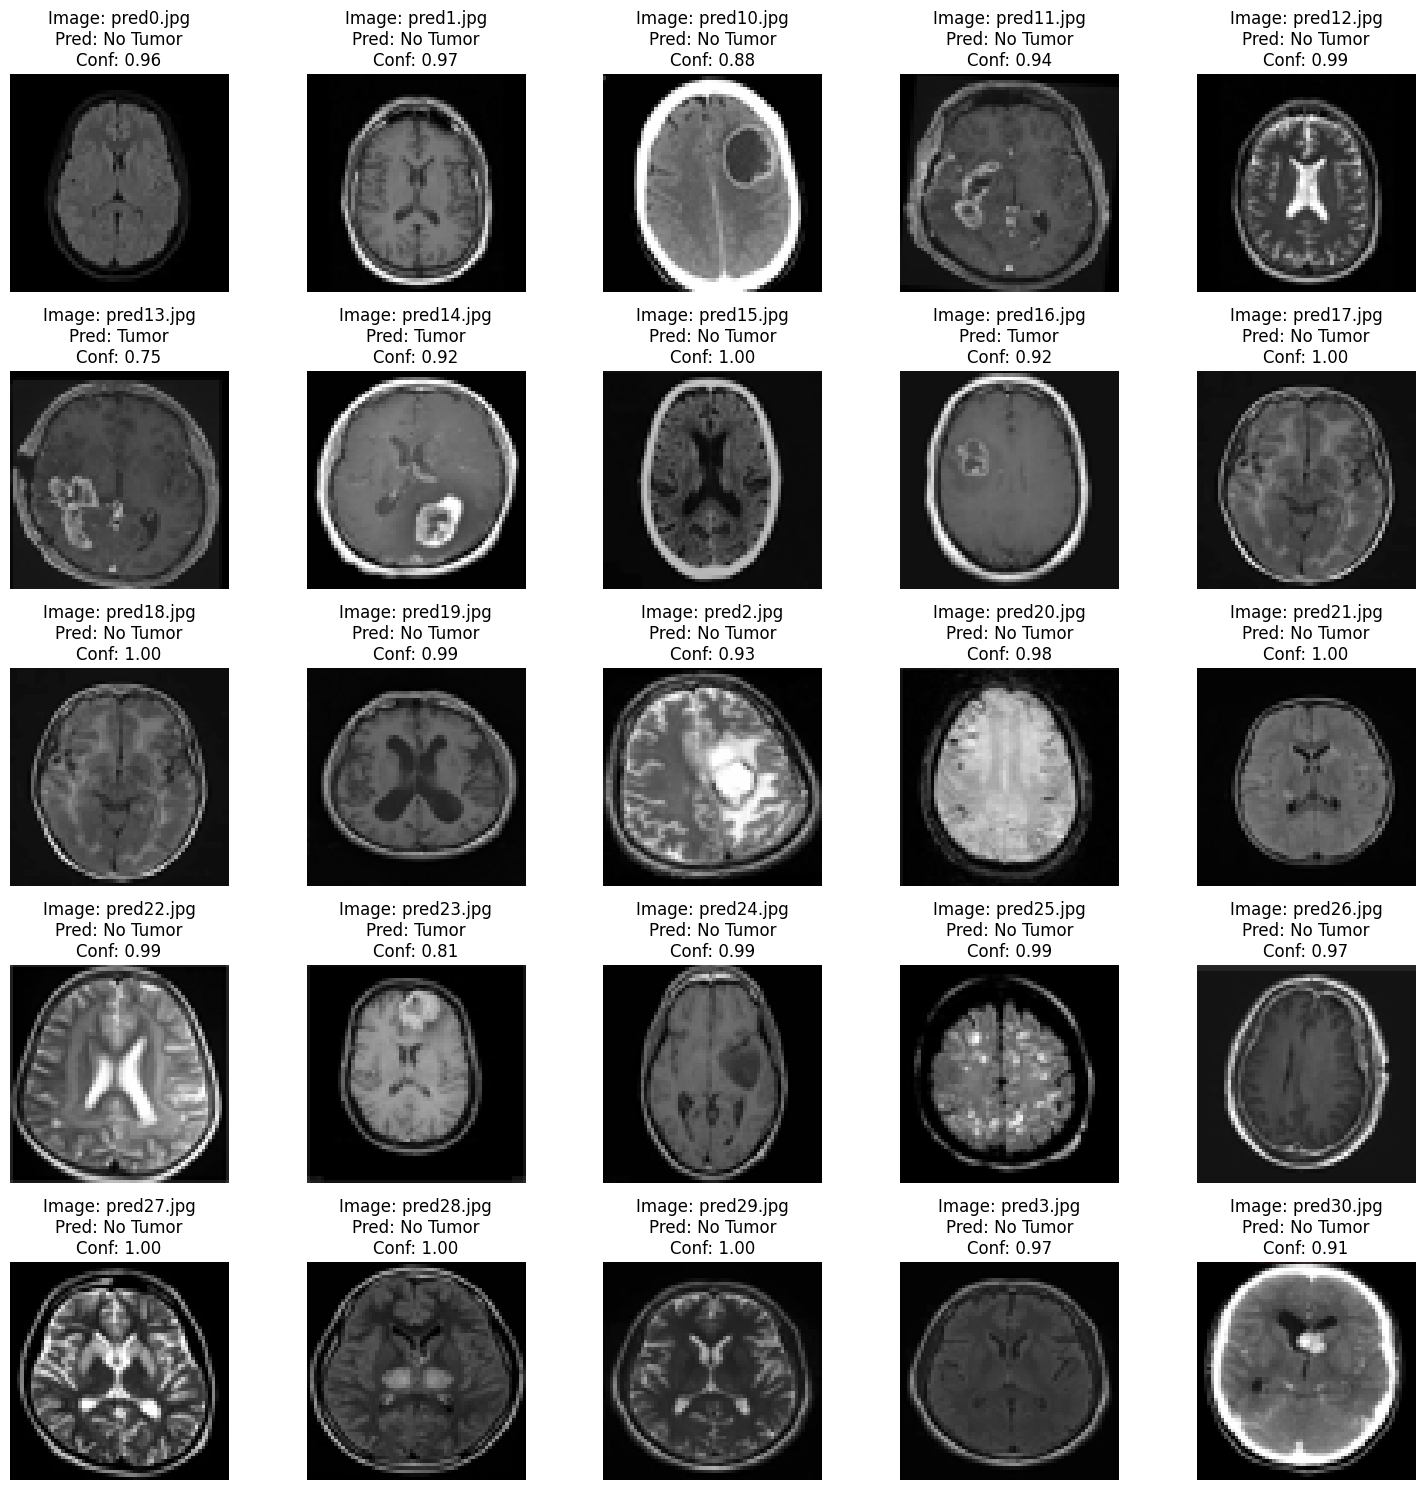

In [38]:
print('\nModified CNN Model Predictions:')
display_results(pred_images_data, cnn_predictions, cnn_predictions_conf, pred_images_names)

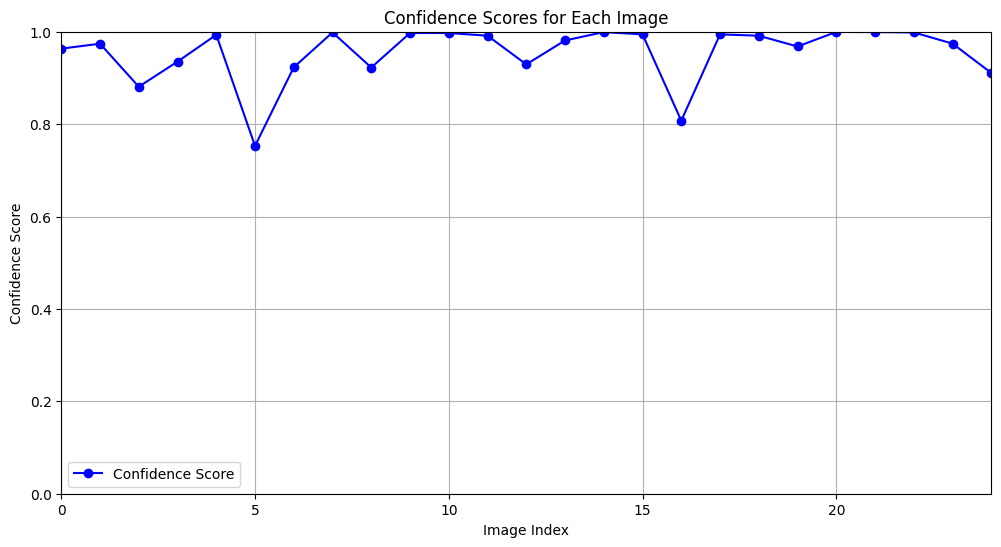

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(cnn_predictions_conf, marker='o', linestyle='-', color='blue', label='Confidence Score')
plt.xlabel('Image Index')
plt.ylabel('Confidence Score')
plt.title('Confidence Scores for Each Image')
plt.ylim(0, 1)
plt.xlim(0,24)
plt.grid(True)
plt.legend()
plt.show()